# NEURAL NETWORKS

Neural networks can be constructed using the `torch.nn` package.

Now that you had a glimpse of `autograd`, `nn` depends on `autograd` to define models and differentiate them. An `nn.Module` contains layers, and a method `forward(input)` that returns the `output`.

For example, look at this network that classifies digit images:

![Architecture of LeNet](https://drive.google.com/uc?id=1RhcX8q7YPXXo6cmN9r3ktnpvTgvAmw6L)

This is an example of LeNet - a popular CNN architecture.

It is a simple feed-forward network. It takes the input, feeds it through several layers one after the other, and then finally gives the output.

A typical training procedure for a neural network is as follows:

* Prepare the dataset
* Define the neural network that has some learnable parameters (or weights)
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`   

![convolution](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif?20190413174630)

## Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 1. Define a Convolutional Neural Network

We will build a neural network similar to LeNet which was shown above and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# You can
print(len(list(net.parameters())))
print(list(net.parameters())[0].shape)

10
torch.Size([6, 3, 5, 5])


![](https://drive.google.com/uc?id=1T-yPih9QgPcq_WDzy2LJXVzCLMoS-Ez6)

In [ ]:
input = torch.randn(1, 3, 32, 32)
out = net(input)
print(out)
print(out.size())

# for batch_size = 16

input_16 = torch.randn(16, 3, 32, 32)
out_16 = net(input_16)
print(out_16.size())

tensor([[ 0.0185, -0.0461, -0.0186, -0.1022, -0.0788,  0.1268,  0.0376, -0.1107,
         -0.0256,  0.0014]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])
torch.Size([16, 10])


In [ ]:
net.zero_grad()
print(net.conv1.bias.grad)

None


**Note:**

`torch.nn` only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width`.

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

Before proceeding further, let’s recap all the classes you’ve seen so far.

**Recap:**

* `torch.Tensor` - A multi-dimensional array with support for autograd operations like `backward()`. Also holds the gradient w.r.t. the tensor.

* `nn.Module` - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.

* `nn.Parameter` - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a `Module`.

* `autograd.Function` - Implements forward and backward definitions of an autograd operation. Every `Tensor` operation creates at least a single `Function` node that connects to functions that created a `Tensor` and encodes its history.

At this point, we covered:

* Defining a neural network
* Processing inputs and calling backward

Still Left:

* Computing the loss
* Updating the weights of the network

## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different [loss functions](https://pytorch.org/docs/nn.html#loss-functions) under the `nn` package . A simple loss is: `nn.MSELoss` which computes the mean-squared error between the input and the target.

For example:

In [ ]:
output = net(input)
print(output.size())
print(output)
target = torch.randn(10)  # a dummy target, for example
target = target.unsqueeze(0) # make it the same shape as output
print(target.size())
print(target)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

torch.Size([1, 10])
tensor([[ 0.0185, -0.0461, -0.0186, -0.1022, -0.0788,  0.1268,  0.0376, -0.1107,
         -0.0256,  0.0014]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])
tensor([[-0.5996,  0.4000,  0.3630, -1.4619,  0.4015,  1.1068,  0.9675, -0.5103,
         -0.1051, -1.9772]])
tensor(0.8712, grad_fn=<MseLossBackward0>)


Now, if you follow `loss` in the backward direction, using its `.grad_fn` attribute, you will see a graph of computations that looks like this:

![](https://drive.google.com/uc?id=1K53Tl3RYDVQBB60V4oo3oIV8lsaqCwZy)

So, when we call `loss.backward()`, the whole graph is differentiated w.r.t. the loss, and all Tensors in the graph that has `requires_grad=True` will have their `.grad` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [ ]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions)
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

((<AddmmBackward0 object at 0x7fcb1accb640>, 0), (None, 0))


## Backprop

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

Now we shall call `loss.backward()`, and have a look at conv1’s bias gradients before and after the backward.

In [ ]:
print('conv1.bias.grad before zeroing grads')
print(net.conv1.bias.grad)

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before zeroing grads
None
conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0250,  0.0031, -0.0122, -0.0030,  0.0094, -0.0100])


**Check out Later:**

The neural network package contains various modules and loss functions that form the building blocks of deep neural networks. A full list with documentation is [here](https://pytorch.org/docs/nn).

The only thing left to learn is:

Updating the weights of the network

## Update the weights

The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

`weight = weight - learning_rate * gradient`

We can implement this using simple Python code:

In [ ]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, there is a small package: `torch.optim` that implements all these methods. Using it is very simple:

In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers

print(net.conv1.bias.grad)

output = net(input)
loss = criterion(output, target)
loss.backward()

print(net.conv1.bias.grad)
print(net.conv1.bias.data)

optimizer.step()    # Does the update

print(net.conv1.bias.grad)
print(net.conv1.bias.data)

None
tensor([-0.0287, -0.0023, -0.0134, -0.0087,  0.0047, -0.0099])
tensor([ 0.0370, -0.0951,  0.0962,  0.1148,  0.0966, -0.0973])
tensor([-0.0287, -0.0023, -0.0134, -0.0087,  0.0047, -0.0099])
tensor([ 0.0373, -0.0951,  0.0963,  0.1149,  0.0966, -0.0972])


**Note:**

Observe how gradient buffers had to be manually set to zero using `optimizer.zero_grad()`. This is because gradients are accumulated as explained in the Backprop section.

### Coming back to CIFAR-10

## 2. Loading and normalizing CIFAR10

Using `torchvision`, it’s extremely easy to load CIFAR10.

## What about data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

* For images, packages such as Pillow, OpenCV are useful
* For audio, packages such as scipy and librosa
* For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

### TORCHVISION.TRANSFORMS

Transforms are common image transformations. They can be chained together using `transforms.Compose`. Additionally, there is the `torchvision.transforms.functional` module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

`transforms.Compose` just clubs all the transforms provided to it. So, all the transforms in the `transforms.Compose` are applied to the input one by one.

### TORCHVISION.DATASETS

All datasets are subclasses of `torch.utils.data.Dataset` i.e, they have `__getitem__` and `__len__` methods implemented. Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples parallelly using `torch.multiprocessing` workers. For example:

`imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')`

`data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)`
      
Refer this [link](https://pytorch.org/docs/stable/torchvision/datasets.html) for more information on `torchvision.datasets`

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 82779861.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(type(trainset))
first_data = trainset[0]
print(first_data)
print(type(first_data))
print(first_data[0].shape)
print(first_data[1])
print(len(testset))

<class 'torchvision.datasets.cifar.CIFAR10'>
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],

<class 'torch.Tensor'>
tensor([9, 1, 2, 5])
torch.Size([4])
<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])


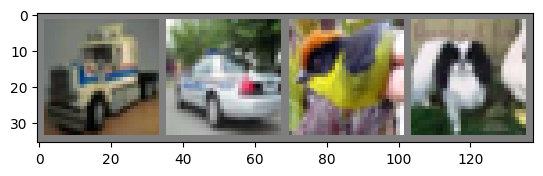

truck   car  bird   dog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(labels))
print(labels)
print(labels.size())
print(type(images))
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.839
[1,  6000] loss: 1.633
[1,  8000] loss: 1.545
[1, 10000] loss: 1.496
[1, 12000] loss: 1.444
[2,  2000] loss: 1.391
[2,  4000] loss: 1.356
[2,  6000] loss: 1.324
[2,  8000] loss: 1.268
[2, 10000] loss: 1.279
[2, 12000] loss: 1.247
Finished Training


Let’s quickly save our trained model:

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch models.

## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

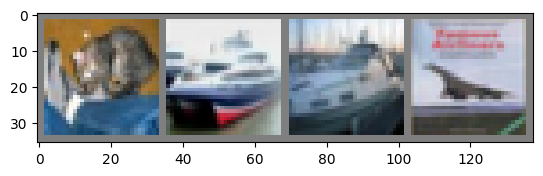

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)
print(outputs)
print(outputs.data.size())

tensor([[-0.2694, -2.2357,  0.5929,  2.1295,  0.4487,  1.5538,  0.3133, -0.4875,
         -0.2325, -2.0704],
        [ 6.4078,  5.0254, -1.4629, -3.5161, -1.6622, -5.0609, -4.4413, -4.5721,
          5.9497,  2.0792],
        [ 2.2523,  2.3875, -0.2967, -1.3615, -1.0941, -2.4190, -2.0768, -1.6805,
          2.5269,  0.4333],
        [ 5.4228,  0.4072,  0.8476, -1.9634,  1.1731, -3.3660, -2.2360, -2.8725,
          3.5981, -0.7914]], grad_fn=<AddmmBackward0>)
torch.Size([4, 10])


The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    print(net.conv1.bias.grad)
    print(net.conv1.bias.data)
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

None
tensor([-0.0743, -0.0471, -0.4186, -0.3792,  0.0076, -0.1917])
None
tensor([-0.0743, -0.0471, -0.4186, -0.3792,  0.0076, -0.1917])
Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 65 %
Accuracy of  bird : 46 %
Accuracy of   cat : 27 %
Accuracy of  deer : 36 %
Accuracy of   dog : 69 %
Accuracy of  frog : 65 %
Accuracy of horse : 58 %
Accuracy of  ship : 58 %
Accuracy of truck : 43 %


## Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training (source: Stanford CS231n)
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

Throughout this colab notebook, we embarked on an exciting journey of PyTorch exploration, starting from the humble beginnings of tensors. We learned how to create and manipulate tensors, the fundamental building blocks of our neural networks. From there, we delved deeper into the world of convolutional neural networks (CNNs), discovering the power of the Conv2d layer. With its ability to extract meaningful features from images, we gained the superhuman ability to distinguish cats from dogs.

But what good is a neural network without the ability to learn from its mistakes? Fear not, for we also learned the magic of backward propagation. With a simple call to backward(), our models embraced the art of learning, adjusting their weights and biases to minimize errors. It's as if our classifiers became students, learning from their own experiences and improving with each iteration.

As we marveled at the wonders of PyTorch, we realized that we had acquired a formidable set of tools. From tensors to convolutions, from linear layers to backpropagation, we had come a long way. Our models now had the capacity to discern patterns, classify images, and even make predictions with remarkable accuracy.

### Have fun and happy PyTorching!